# Downloading ERA5 Data in Python

[Florian Roscheck](https://www.linkedin.com/in/florianroscheck/), 2020-03-15

This notebook describes how to download data from the [ERA5 climate model](https://www.ecmwf.int/en/forecasts/datasets/reanalysis-datasets/era5) in Python. The data downloaded in this notebook were used to artificially create [met mast data](https://github.com/flrs/predicting_the_wind/blob/master/data_acquisition/synthesizing_a_wind_speed_time_series.ipynb) that were used in [this presentation](https://github.com/flrs/predicting_the_wind) about data science in wind resource assessment.

Mandatory statement according to ERA5 terms of use:
> Generated using Copernicus Climate Change Service information 1979-2020


## Prerequisites and a Warning

In order for this notebook to run, you need the `cdsapi`, a Python module to download ERA5 data. You can install it via `pip install cdsapi`. You also need to set up a (free) account at the Copernicus climate portal and store your user credentials for the portal in a file on your local machine. All of this is described in detail in the [instructions on PyPI](https://pypi.org/project/cdsapi/).

**Warning**: Downloading the ERA5 data can take several hours. If you simply "run all cells" in this notebook, be prepared to wait a long time. None of the raw data has been uploaded to the GitHub repository, only the transformed data have been included.

## About ERA5

ERA5 is a long-term climate reanalysis dataset. That means it is a (global) climate model that has been adjusted with actual climate measurements to deliver the best possible estimate of past climate on the planet. ERA5 includes information about many meteorological parameters and is available in 1-hour resolution from 1979 onwards.

For more information, check out what the creators of ERA5 at the Copernicus Climate Change Service have to say about [what ERA5 is](https://confluence.ecmwf.int/display/CKB/What+is+ERA5).

## Deciding Which Data to Download

For the data science in wind resource assessment presentation, we are particularly interested in ERA5 grid points around San Diego's AI incubator [The Sandbox](https://www.thesandbox.ai/). Let's come up with an area of interest that we can use to filter ERA5 grid points.

In [1]:
area_of_interest = [[33.1, -117.3],
                    [32.7, -117.3],
                    [32.7, -116.9],
                    [33.1, -116.9]]

In [2]:
import folium
from folium.vector_layers import Polygon

sandbox_loc = [32.896278, -117.219553]

m = folium.Map(location=sandbox_loc, tiles='Stamen Terrain', zoom_start=11)
folium.Marker(sandbox_loc, popup='The Sandbox').add_to(m)
Polygon(area_of_interest, color='red').add_to(m)

m

## 2020 Data: Our First Download

We get our first download from the, up to today, short 2020 data. It is good that the data only last until March because they are faster to extract and download from the ERA5 server.

We want to use these data to get a feel for the strcture of the dataset and make sure that we have everything we need for when we download 20 years of data.

The request below was assembled from the [ERA5 API Request Helper](https://cds.climate.copernicus.eu/cdsapp#!/dataset/reanalysis-era5-single-levels?tab=form) that you find on the bottom of the linked page.

In [34]:
# Download 2020 data

import cdsapi

c = cdsapi.Client()

c.retrieve(
    'reanalysis-era5-single-levels',
    {
        'product_type': 'reanalysis',
        'variable': [
            '100m_u_component_of_wind', '100m_v_component_of_wind', '2m_temperature',
        ],
        'year': '2020',
        'month': [
            '01', '02', '03',
        ],
        'day': [
            '01', '02', '03',
            '04', '05', '06',
            '07', '08', '09',
            '10', '11', '12',
            '13', '14', '15',
            '16', '17', '18',
            '19', '20', '21',
            '22', '23', '24',
            '25', '26', '27',
            '28', '29', '30',
            '31',
        ],
        'time': [
            '00:00', '01:00', '02:00',
            '03:00', '04:00', '05:00',
            '06:00', '07:00', '08:00',
            '09:00', '10:00', '11:00',
            '12:00', '13:00', '14:00',
            '15:00', '16:00', '17:00',
            '18:00', '19:00', '20:00',
            '21:00', '22:00', '23:00',
        ],
        'area' : [area_of_interest[0][0], area_of_interest[0][1], area_of_interest[1][0], area_of_interest[2][1]], # North, West, South, East. Default: global
        'format': 'netcdf',
    },
    '../data/era5_2020.nc')

2020-03-07 09:26:46,836 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-single-levels
2020-03-07 09:26:47,801 INFO Request is queued
2020-03-07 09:26:48,985 INFO Request is running
2020-03-07 09:31:08,080 INFO Request is completed
2020-03-07 09:31:08,086 INFO Downloading http://136.156.133.46/cache-compute-0015/cache/data0/adaptor.mars.internal-1583602007.8021555-27962-22-75b948c9-0eb2-4cf7-9f5c-08e409d04fa2.nc to ./data/download.nc (42.2K)
2020-03-07 09:31:08,643 INFO Download rate 76K/s   


Result(content_length=43192,content_type=application/x-netcdf,location=http://136.156.133.46/cache-compute-0015/cache/data0/adaptor.mars.internal-1583602007.8021555-27962-22-75b948c9-0eb2-4cf7-9f5c-08e409d04fa2.nc)

## Understanding the ERA5 Data Structure <a id="structure"></a>

In this section, we exlore the freshly downloaded ERA5 data to understand its structure. We also lay the groundwork for transforming the data for wind resource assessment. We specifically want to know:

- Which grid points does ERA5 provide for the San Diego area?
- How are wind speed data represented?
- How is temperature information incorporated?
- How is time represented in ERA5 data?

In [3]:
# Open 2020 dataset and show meta info

import netCDF4

f = netCDF4.Dataset('../data/era5_2020.nc')

f

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF3_64BIT_OFFSET data model, file format NETCDF3):
    Conventions: CF-1.6
    history: 2020-03-07 17:30:05 GMT by grib_to_netcdf-2.16.0: /opt/ecmwf/eccodes/bin/grib_to_netcdf -S param -o /cache/data0/adaptor.mars.internal-1583602007.8021555-27962-22-75b948c9-0eb2-4cf7-9f5c-08e409d04fa2.nc /cache/tmp/75b948c9-0eb2-4cf7-9f5c-08e409d04fa2-adaptor.mars.internal-1583602007.8026836-27962-9-tmp.grib
    dimensions(sizes): longitude(2), latitude(2), time(1486)
    variables(dimensions): float32 longitude(longitude), float32 latitude(latitude), int32 time(time), int16 u100(time,latitude,longitude), int16 v100(time,latitude,longitude), int16 t2m(time,latitude,longitude)
    groups: 

Just as we requested, the dataset includes speed data for two directions (`u100` and `v100`) as well as temperature data (`t2m`) for a time series (`time`) with 1486 samples for four grid points (`latitude` and `longitude`).

### ERA5 Grid Points

Let's see where the grid points are!

In [4]:
# Plot grid points of ERA5 dataset

import itertools

m = folium.Map(location=sandbox_loc, tiles='Stamen Terrain', zoom_start=10)
folium.Marker(sandbox_loc, popup='The Sandbox').add_to(m)
Polygon(area_of_interest, color='red').add_to(m)

lats = []
lons = []
for lat, lon in zip(f.variables['latitude'][:].data, f.variables['longitude'][:].data):
    lats.append(lat)
    lons.append(lon)

grid_points = []
for nx, (lat, lon) in enumerate(itertools.product(lats, lons)):
    grid_points.append([lat, lon])
    folium.Marker([lat, lon], popup='Grid Point: {}'.format(nx), icon=folium.Icon(color='green')).add_to(m)

m

All 4 grid points are within the boundary we defined – it looks as if the ERA5 server understood our request. How is the spacial resolution of the data?

In [5]:
print('Latitudinal Resolution: {} deg'.format(lats[1]-lats[0]))
print('Longitudinal Resolution: {} deg'.format(lons[1]-lons[0]))

Latitudinal Resolution: -0.25 deg
Longitudinal Resolution: 0.25 deg


For atmospheric data, the ERA5 dataset offers 0.25 deg as a native resolution, as documented [here](https://confluence.ecmwf.int/display/CKB/ERA5%3A+What+is+the+spatial+reference). This means that we have the highest resolution data available and avoid any interpolation.

### Wind Speed (and Direction) Data Representation

As described in the [ERA5 dataset documentation](https://cds.climate.copernicus.eu/cdsapp#!/dataset/reanalysis-era5-single-levels?tab=overview), the two wind speed components `u100` and `v100` represent the wind moving towards the East and towards the North, respectively, at 100 m above the Earth's surface, in m/s.

Given the two perpendicular speed signals, we can calculate a wind speed vector that carries both wind speed (magnitude of the vector) and wind direction (orientation of the vector) information. Let's build such a vector.

In [6]:
# Print dimensions of speed variable

f.variables['u100'].dimensions

('time', 'latitude', 'longitude')

In [7]:
import pandas as pd
import numpy as np

grid_pt = 0

u_100 = pd.Series(f.variables['u100'][:,grid_pt,grid_pt])
v_100 = pd.Series(f.variables['v100'][:,grid_pt,grid_pt])

# Get magnitude of speed vector
spd_100 = pd.Series(data=np.sqrt(u_100**2+v_100**2))

The [arctan2](https://docs.scipy.org/doc/numpy/reference/generated/numpy.arctan2.html) function is especially handy for calculating vector orientations from x and y coordinates. We should also consider that wind direction is measured clockwise from the North.

In [8]:
# Get direction of speed vector

dir_100  = pd.Series(90-(np.arctan2(v_100, -u_100)*180.0/np.pi))
dir_100[dir_100<=0] = dir_100[dir_100<=0] + 360

Since the formula in the previous cell is a little tricky to grasp, let's verify that we got the wind directions right. A little googling reveals that the primary wind direction of San Diego is Eastward, that means wind is coming from the West [source](https://www.windfinder.com/windstatistics/san_diego_airport).

Let's plot a histogram to see if we can confirm this wind direction by means of our data. We would expect to see a spike around 270 degree, indicating that the wind is blowing from the West.

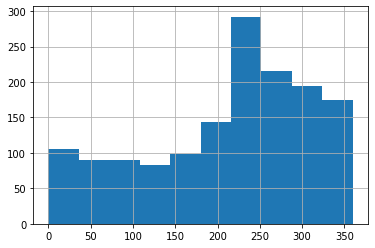

In [9]:
# Plot histogram of directions

dir_100.hist();

The plot confirms that we got the wind direction right.

### Temperature Data

Just as the [ERA5 dataset documentation](https://cds.climate.copernicus.eu/cdsapp#!/dataset/reanalysis-era5-single-levels?tab=overview) tells us, temperature is represented in Kelvin. While useful in science, in wind resource assessment degree Celsius is the more common unit. To transform Kelvin into degree Celsius, we only need to subtract 273.15 K from the ERA5 temperature.

In [10]:
# Transform temperature data and print basic stats

t_2 = pd.Series(f.variables['t2m'][:,grid_pt,grid_pt]) - 273.15

t_2.describe().round(1)

count    1486.0
mean       13.6
std         2.6
min         6.6
25%        11.7
50%        13.4
75%        15.1
max        22.2
dtype: float64

The transformation seems to make sense, a mean temperature of 13.6 degree Celsius, with a minimum of 6.6 degree Celsius, sounds reasonable for the beginning of the year in sunny San Diego.

### ERA5 Time Dimension

The last question we need to solve to fully understand the ERA5 data is how time is represented. Luckily, netCDF offers a unit field that bears some useful info.

In [11]:
# Show `time` variable description

f.variables['time']

<class 'netCDF4._netCDF4.Variable'>
int32 time(time)
    units: hours since 1900-01-01 00:00:00.0
    long_name: time
    calendar: gregorian
unlimited dimensions: 
current shape = (1486,)
filling on, default _FillValue of -2147483647 used

So, to get the time dimension right we need to add the amount of hours in the `time` variable to `1900-01-01 00:00:00.0`.

In [12]:
# Transform time dimension and show start and end time of dataset

from datetime import datetime, timedelta

time = [datetime(year=1900, month=1, day=1) 
        + timedelta(hours=int(x)) for x in f.variables['time'][:]]

print(time[0])
print(time[-1])

2020-01-01 00:00:00
2020-03-02 21:00:00


Nice, these times look like exactly what we ordered when we downloaded the dataset! Now, we just need to make sure that the time zone of the data is the local time zone in San Diego, since this is the area we are particularly interested in.

A great way to explore time shifts in meteorological data is by looking at the temperature signal. One would expect it to be warm during the day and cold during the night. Let's check it out!

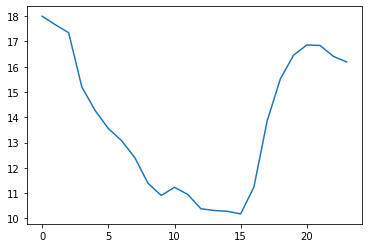

In [14]:
# Plot hour vs temperature

from matplotlib import pyplot as plt

plt.plot([t.hour for t in time[:24]], t_2[:24]);

That does not look right. The data does not seem to be in San Diego's time zone. The [ERA5 documentation](https://confluence.ecmwf.int/pages/viewpage.action?pageId=85402030#ERA5terminology:analysisandforecast;timeandsteps;instantaneousandaccumulatedandmeanratesandmin/maxparameters-'time'inanalyses) states that the time is in UTC. This means we need to convert all time data from UTC to San Diego's local timezone.

In [15]:
# Convert UTC into San Diego timezone

import pytz

def convert_to_san_diego_timezone(date):
    san_diego_tz = pytz.timezone('America/Los_Angeles')
    return pytz.utc.normalize(pytz.utc.localize(date)).astimezone(san_diego_tz).replace(tzinfo=None)

time_in_tz = [convert_to_san_diego_timezone(t) for t in time]

print(time_in_tz[0])
print(time_in_tz[-1])

2019-12-31 16:00:00
2020-03-02 13:00:00


It looks as if that shifted our data by 8 hours. Let's plot temperature again and see if it aligns with our expectation.

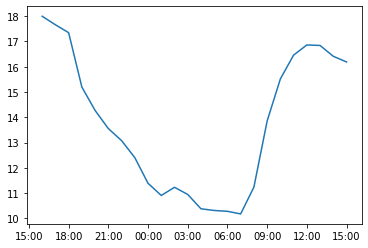

In [16]:
# Plot hour vs temperature

import matplotlib.dates as mdates

plt.plot(time_in_tz[:24], t_2[:24]);

hour_formatter = mdates.DateFormatter('%H:%M')
plt.gca().xaxis.set_major_formatter(hour_formatter)

It looks as if the time transformation works – temperatures fall during the night and rise with the sun.

## Bringing it all Together: Exploring Wind Over Time

Now that we have our data in place, let's use it to generate some informative plots. It always helps to see data points in context to get a feeling for the information your data conveys.

This being said – this little venture into data exploration is optional and if you feel like skipping it, learn [further down](#download_multiple_years) how to download 20 years of ERA5 data.

TODO: Add link

First, let's plot the wind speed vector. Feel free to change the `sample_no` variable to see how the wind speed vector changes over time.

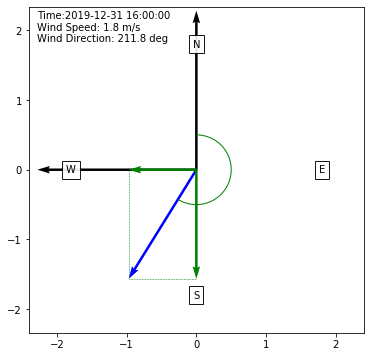

In [17]:
# Plot wind speed vector

sample_no = 0 # Change this to choose a different sample from the data set

from matplotlib import pyplot as plt
from matplotlib.patches import Arc

def plot_wind_vector(u_100_, v_100_, spd_100_, dir_100_, time_):
    fig = plt.figure(figsize=(6,6))

    x = -u_100_
    y = v_100_
    theta = dir_100_
    extent = np.max([np.ceil(np.abs(x)), np.ceil(np.abs(y))])*1.2

    plt.quiver(0, 0, -extent*0.95, 0, scale=1, angles='xy', scale_units='xy', color='black')
    plt.quiver(0, 0, 0, extent*0.95, scale=1, angles='xy', scale_units='xy', color='black')
    plt.quiver(0, 0, x, y, scale=1, angles='xy', scale_units='xy', color='b')
    plt.quiver(0, 0, x, 0, scale=1, angles='xy', scale_units='xy', color='g')
    plt.quiver(0, 0, 0, y, scale=1, angles='xy', scale_units='xy', color='g')
    plt.plot([x,x],[0,y], color='g', ls='--', lw=0.5)
    plt.plot([0,x],[y,y], color='g', ls='--', lw=0.5)

    plt.gca().add_patch(Arc([0,0], 1, 1, angle=0.0, theta1=90-theta, theta2=90.0, color='g'))
    plt.text(0, extent*0.75, 'N', ha='center', va='center', bbox=dict(facecolor='white', alpha=0.9))
    plt.text(extent*0.75, 0, 'E', ha='center', va='center', bbox=dict(facecolor='white', alpha=0.9))
    plt.text(0, -extent*0.75, 'S', ha='center', va='center', bbox=dict(facecolor='white', alpha=0.9))
    plt.text(-extent*0.75, 0, 'W', ha='center', va='center', bbox=dict(facecolor='white', alpha=0.9))

    info = 'Time:{}\nWind Speed: {:.1f} m/s\nWind Direction: {:.1f} deg'.format(time_, spd_100_, dir_100_)
    plt.text(-extent*0.95,extent*0.95, info, ha='left', va='top')

    plt.gca().axis('equal')
    plt.gca().axis([-extent, extent, -extent, extent])
    plt.show()

plot_wind_vector(u_100_=u_100[sample_no],
                 v_100_=v_100[sample_no],
                 spd_100_=spd_100[sample_no],
                 dir_100_=dir_100[sample_no],
                 time_=time_in_tz[sample_no])

If you have played around enough, you might have noticed how interesting it is to observe how wind speed and direction change over time. The natural question arises if there are any observable patterns in San Diego's wind regime.

To shed light on this, we produce a rather unconventional plot that is based on the wind vector plot above. Let's plot the wind vector over time, over 3 consecutive days. This will help us understand diurnal patterns in wind speed and direction.

Adjust the variable `start_day` if you are interested in inspecting additional days.

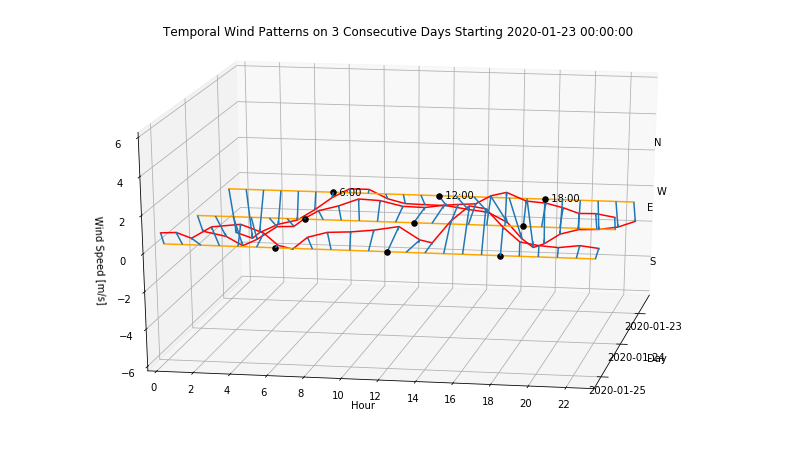

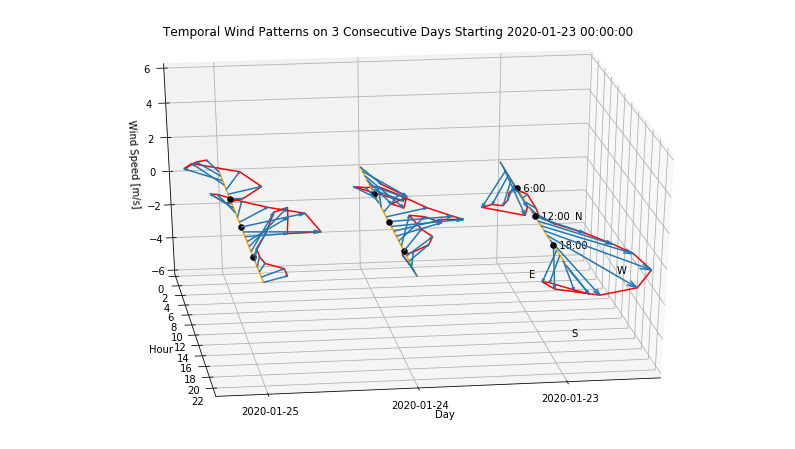

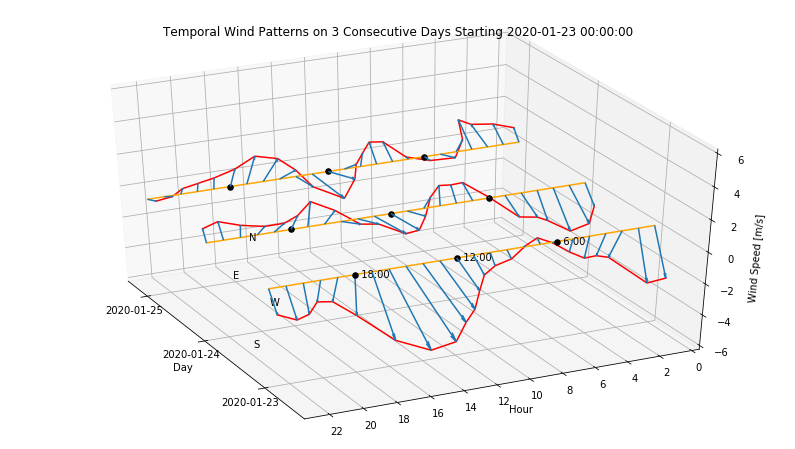

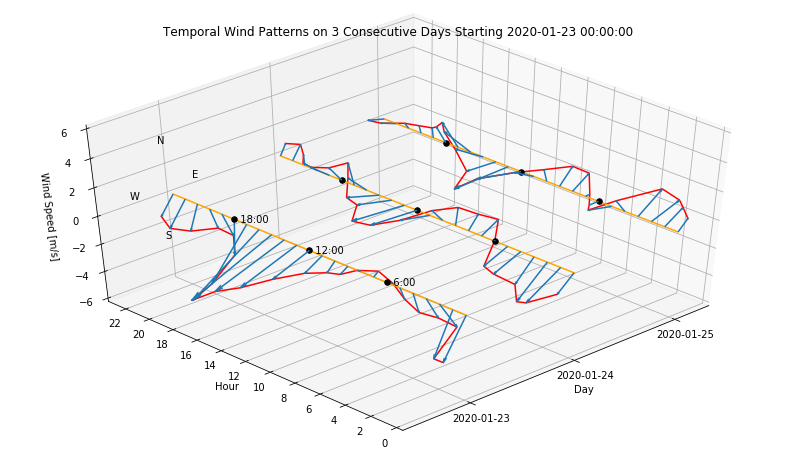

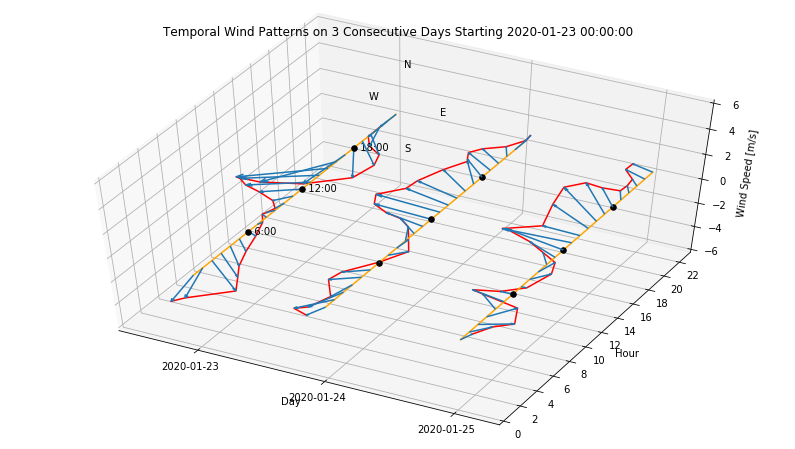

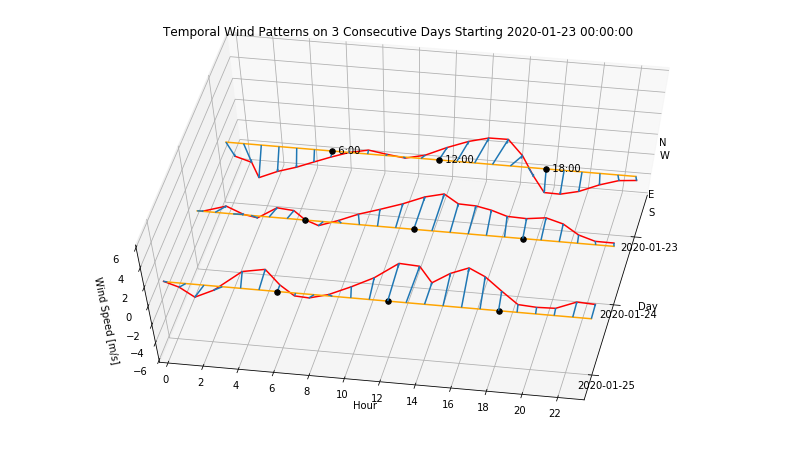

In [20]:
# Plot diurnal wind speed patterns

start_day = 22

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.animation as animation

def make_3d_fig(sample_nos=None, elev=None, azim=None):
    fig = plt.figure(figsize=(14,8))
    ax = fig.add_subplot(111, projection='3d')
    if elev:
        ax.elev = elev
    if azim:
        ax.azim = azim

    days = range(int(np.floor(len(sample_nos)/24)))
    all_xs = []
    all_ys = []
    all_zs = []
    day_centers = []
    day_dates = []
    for day in days:
        xs = []
        ys = []
        zs = []
        day_samples = sample_nos[int(day*24):int((day+1)*24)]
        day_date = time_in_tz[day_samples[0]] 
        day_center = day*7
        for sample_nx, sample in enumerate(day_samples):
            x = -u_100[sample]
            y = sample_nx
            z = v_100[sample]
            ax.quiver(day_center,y,0,x,0,z,length=1.0,arrow_length_ratio=0.1)
            xs.append(x+day_center)
            ys.append(y)
            zs.append(z)
        ax.scatter(day_center, 18, 0, color='black',s=30)
        ax.scatter(day_center, 12, 0, color='black',s=30)
        ax.scatter(day_center, 6, 0, color='black',s=30)
        ax.plot(xs=xs, ys=ys, zs=zs, color='red')
        ax.plot(xs=[day_center]*len(day_samples),ys=ys,zs=[0]*len(day_samples), color='orange')
        all_xs = all_xs + xs
        all_ys = all_ys + ys
        all_zs = all_zs + zs
        day_centers.append(day_center)
        day_dates.append(day_date)
    ax.text(0,18,0,'  18:00',ha='left', va='center')
    ax.text(0,12,0,'  12:00',ha='left', va='center')
    ax.text(0,6,0,'  6:00',ha='left', va='center')
    ax.text(0,24,3,'N',va='bottom')
    ax.text(0,24,-3,'S',va='top')
    ax.text(2,24,0,'E',ha='left',)
    ax.text(-2,24,0,'W',ha='left') 
    x_extent = np.ceil(np.max(all_zs+all_xs))
    z_extent = np.ceil(np.max(spd_100[sample_nos]))
    ax.set_xticks(day_centers)
    ax.set_xticklabels([d.strftime('%Y-%m-%d') for d in day_dates])
    ax.set_xlim(-4, x_extent)
    ax.set_yticks(range(0,24,2))
    ax.set_ylim(0, 23)
    ax.set_zlim(-z_extent, z_extent)
    ax.set_xlabel('Day')
    ax.set_ylabel('Hour')
    ax.set_zlabel('Wind Speed [m/s]')
    ax.set_title('Temporal Wind Patterns on 3 Consecutive Days Starting {}'.format(day_dates[0]))
    return fig

def rotate_3d_fig(sample_nos):
    figs = []
    steps = 6
    for azim, elev in zip(np.linspace(0,360,steps), np.linspace(20,60,steps)):
        figs.append(make_3d_fig(sample_nos, azim=azim+10, elev=elev))
    return figs

figs = rotate_3d_fig(sample_nos = list(range(8+start_day*24,24*3+8+start_day*24)))

Let's take a minute to look at the (relatively complex) plots. What do you notice? Several things stand out:

- There seems to be a clear pattern of lower wind speeds in the morning hours (around 06:00), paired with a change in wind direction.
- In the afternoon, strong breezes tend to blow into Western/South-Western direction.
- After sunset, the strong breezes seem to slow down.
- The strong winds of January 23 are less pronounced and slightly change direction in the two following days.

Thinking about San Diego's location right by the Pacific Ocean (which is to the West of the city), one can try to make a connection to the movement of air masses between the ocean and inland. For example, if winds pick up after sunrise and move towards the West, is it because dry, warm, high-pressure air pushes from inland onto the cool ocean? A meteorologist would be able to tell us more. Don't forget to play around with the `start_day` parameter to find more interesting patterns.


## Downloading Multiple Years of Data<a id="download_multiple_years"></a>

Now that we have a reasonably good understanding of the structure of the data, let's download and save it. We are interested in the last 20 years of data.

<div class="alert alert-warning">
Executing the following cell will take some time (it took me 8 hours).
</div>

In [133]:
# Download 20 years of data

from tqdm import tqdm

def get_era5_year(year):
    print('Now downloading year {}...'.format(year), end='')
    c.retrieve(
        'reanalysis-era5-single-levels',
        {
            'product_type': 'reanalysis',
            'variable': [
                '100m_u_component_of_wind', '100m_v_component_of_wind', '2m_temperature',
            ],
            'year': str(year),
            'month': [
                '01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12'
            ],
            'day': [
                '01', '02', '03',
                '04', '05', '06',
                '07', '08', '09',
                '10', '11', '12',
                '13', '14', '15',
                '16', '17', '18',
                '19', '20', '21',
                '22', '23', '24',
                '25', '26', '27',
                '28', '29', '30',
                '31',
            ],
            'time': [
                '00:00', '01:00', '02:00',
                '03:00', '04:00', '05:00',
                '06:00', '07:00', '08:00',
                '09:00', '10:00', '11:00',
                '12:00', '13:00', '14:00',
                '15:00', '16:00', '17:00',
                '18:00', '19:00', '20:00',
                '21:00', '22:00', '23:00',
            ],
            'area' : [area_of_interest[0][0], area_of_interest[0][1], area_of_interest[1][0], area_of_interest[2][1]], # North, West, South, East. Default: global
            'format': 'netcdf',
        },
        '../data/era5_{}.nc'.format(year))
    print('done!')
    
for year in tqdm(range(2020-20,2020)):
    get_era5_year(year)

  0%|          | 0/20 [00:00<?, ?it/s]2020-03-07 13:51:16,516 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-single-levels


Now downloading year 2000...

2020-03-07 13:51:17,420 INFO Request is queued
2020-03-07 13:51:18,616 INFO Request is running
2020-03-07 14:17:46,211 INFO Request is completed
2020-03-07 14:17:46,221 INFO Downloading http://136.156.133.41/cache-compute-0013/cache/data8/adaptor.mars.internal-1583617877.514917-18665-33-16f82bea-f0f9-40d5-9034-c57494238134.nc to ./data/era5_2000.nc (241.7K)

  0%|          | 0.00/242k [00:00<?, ?B/s]
  5%|▍         | 11.0k/242k [00:00<00:02, 109kB/s]
 15%|█▌        | 37.0k/242k [00:00<00:01, 130kB/s]
 31%|███       | 75.0k/242k [00:00<00:01, 162kB/s]
 57%|█████▋    | 137k/242k [00:00<00:00, 208kB/s] 
                                                 2020-03-07 14:17:47,239 INFO Download rate 237.9K/s
  5%|▌         | 1/20 [26:31<8:23:49, 1591.03s/it]2020-03-07 14:17:47,550 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-single-levels


done!
Now downloading year 2001...

2020-03-07 14:17:47,943 INFO Request is queued
2020-03-07 14:17:49,166 INFO Request is running
2020-03-07 14:42:16,892 INFO Request is completed
2020-03-07 14:42:16,899 INFO Downloading http://136.156.133.42/cache-compute-0014/cache/data3/adaptor.mars.internal-1583619468.034069-8550-7-600cbbdb-e4e2-43da-a4eb-3b739d8582fc.nc to ./data/era5_2001.nc (241.1K)

  0%|          | 0.00/241k [00:00<?, ?B/s]
  9%|▊         | 21.0k/241k [00:00<00:01, 201kB/s]
 21%|██        | 51.0k/241k [00:00<00:00, 224kB/s]
 46%|████▌     | 110k/241k [00:00<00:00, 276kB/s] 
 95%|█████████▍| 229k/241k [00:00<00:00, 359kB/s]
                                                 2020-03-07 14:42:18,015 INFO Download rate 216.3K/s
 10%|█         | 2/20 [51:01<7:46:29, 1554.96s/it]2020-03-07 14:42:18,328 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-single-levels


done!
Now downloading year 2002...

2020-03-07 14:42:18,626 INFO Request is queued
2020-03-07 14:42:19,853 INFO Request is running
2020-03-07 15:04:52,080 INFO Request is completed
2020-03-07 15:04:52,087 INFO Downloading http://136.156.133.32/cache-compute-0009/cache/data5/adaptor.mars.internal-1583620938.6207058-16443-38-60425d1b-f4ed-488e-99f0-6faaac5f8316.nc to ./data/era5_2002.nc (241.1K)

  0%|          | 0.00/241k [00:00<?, ?B/s]
  5%|▍         | 12.0k/241k [00:00<00:02, 106kB/s]
 16%|█▌        | 38.0k/241k [00:00<00:01, 127kB/s]
 31%|███       | 74.0k/241k [00:00<00:01, 158kB/s]
 54%|█████▍    | 130k/241k [00:00<00:00, 202kB/s] 
 90%|████████▉ | 216k/241k [00:00<00:00, 262kB/s]
                                                 2020-03-07 15:04:53,209 INFO Download rate 215.2K/s
 15%|█▌        | 3/20 [1:13:37<7:03:36, 1495.06s/it]2020-03-07 15:04:53,630 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-single-levels


done!
Now downloading year 2003...

2020-03-07 15:04:54,184 INFO Request is queued
2020-03-07 15:04:55,443 INFO Request is running
2020-03-07 15:27:22,160 INFO Request is completed
2020-03-07 15:27:22,166 INFO Downloading http://136.156.132.153/cache-compute-0002/cache/data0/adaptor.mars.internal-1583622294.1521022-28362-32-d26e6302-44ab-4e25-b860-113445d1b0ca.nc to ./data/era5_2003.nc (241.1K)

  0%|          | 0.00/241k [00:00<?, ?B/s]
  8%|▊         | 19.0k/241k [00:00<00:01, 195kB/s]
 22%|██▏       | 54.0k/241k [00:00<00:00, 225kB/s]
 53%|█████▎    | 127k/241k [00:00<00:00, 284kB/s] 
                                                 2020-03-07 15:27:22,906 INFO Download rate 326.1K/s
 20%|██        | 4/20 [1:36:06<6:27:02, 1451.38s/it]2020-03-07 15:27:23,100 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-single-levels


done!
Now downloading year 2004...

2020-03-07 15:27:23,539 INFO Request is queued
2020-03-07 15:27:24,726 INFO Request is running
2020-03-07 15:51:51,372 INFO Request is completed
2020-03-07 15:51:51,378 INFO Downloading http://136.156.133.41/cache-compute-0013/cache/data5/adaptor.mars.internal-1583623643.5725393-9663-17-22944f16-3199-4bcb-b946-10cd812f3a00.nc to ./data/era5_2004.nc (241.7K)

  0%|          | 0.00/242k [00:00<?, ?B/s]
 10%|▉         | 23.0k/242k [00:00<00:00, 235kB/s]
 24%|██▍       | 59.0k/242k [00:00<00:00, 261kB/s]
 57%|█████▋    | 137k/242k [00:00<00:00, 326kB/s] 
                                                 2020-03-07 15:51:52,132 INFO Download rate 320.8K/s
 25%|██▌       | 5/20 [2:00:35<6:04:11, 1456.78s/it]2020-03-07 15:51:52,478 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-single-levels


done!
Now downloading year 2005...

2020-03-07 15:51:52,729 INFO Request is queued
2020-03-07 15:51:53,921 INFO Request is running
2020-03-07 16:16:20,961 INFO Request is completed
2020-03-07 16:16:20,967 INFO Downloading http://136.156.132.198/cache-compute-0003/cache/data6/adaptor.mars.internal-1583625112.9152045-22888-38-6e93c231-91f0-40d7-a86b-d1f0deccbae2.nc to ./data/era5_2005.nc (241.1K)

  0%|          | 0.00/241k [00:00<?, ?B/s]
 13%|█▎        | 31.0k/241k [00:00<00:00, 300kB/s]
 25%|██▍       | 60.0k/241k [00:00<00:00, 294kB/s]
 57%|█████▋    | 137k/241k [00:00<00:00, 362kB/s] 
                                                 2020-03-07 16:16:21,785 INFO Download rate 294.9K/s
 30%|███       | 6/20 [2:25:06<5:40:51, 1460.82s/it]2020-03-07 16:16:22,705 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-single-levels


done!
Now downloading year 2006...

2020-03-07 16:16:23,934 INFO Request is queued
2020-03-07 16:16:26,856 INFO Request is running
2020-03-07 16:40:53,748 INFO Request is completed
2020-03-07 16:40:53,754 INFO Downloading http://136.156.132.198/cache-compute-0003/cache/data1/adaptor.mars.internal-1583626586.1134305-12653-5-63e236ba-48d4-4ebe-ada8-614859f5a707.nc to ./data/era5_2006.nc (241.1K)

  0%|          | 0.00/241k [00:00<?, ?B/s]
  5%|▍         | 12.0k/241k [00:00<00:03, 76.7kB/s]
 16%|█▌        | 38.0k/241k [00:00<00:02, 93.7kB/s]
 31%|███       | 74.0k/241k [00:00<00:01, 120kB/s] 
 45%|████▍     | 108k/241k [00:00<00:00, 149kB/s] 
 62%|██████▏   | 149k/241k [00:00<00:00, 150kB/s]
                                                 2020-03-07 16:40:55,094 INFO Download rate 180.1K/s
 35%|███▌      | 7/20 [2:49:38<5:17:16, 1464.37s/it]2020-03-07 16:40:55,383 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-single-levels


done!
Now downloading year 2007...

2020-03-07 16:40:55,933 INFO Request is queued
2020-03-07 16:40:57,196 INFO Request is running
2020-03-07 17:05:25,019 INFO Request is completed
2020-03-07 17:05:25,025 INFO Downloading http://136.156.133.25/cache-compute-0008/cache/data7/adaptor.mars.internal-1583628064.46883-4177-35-e5c8607c-4c7b-4a70-ad09-b6701c92ca74.nc to ./data/era5_2007.nc (241.1K)

  0%|          | 0.00/241k [00:00<?, ?B/s]
  6%|▌         | 15.0k/241k [00:00<00:01, 151kB/s]
 20%|█▉        | 48.0k/241k [00:00<00:01, 181kB/s]
 44%|████▍     | 107k/241k [00:00<00:00, 229kB/s] 
 93%|█████████▎| 224k/241k [00:00<00:00, 302kB/s]
                                                 2020-03-07 17:05:25,830 INFO Download rate 300.2K/s
 40%|████      | 8/20 [3:14:10<4:53:17, 1466.43s/it]2020-03-07 17:05:26,600 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-single-levels


done!
Now downloading year 2008...

2020-03-07 17:05:27,048 INFO Request is queued
2020-03-07 17:05:28,234 INFO Request is running
2020-03-07 17:29:56,212 INFO Request is completed
2020-03-07 17:29:56,225 INFO Downloading http://136.156.133.32/cache-compute-0009/cache/data8/adaptor.mars.internal-1583629528.0471444-1354-21-37817532-0991-4668-8c21-a3a450ea64db.nc to ./data/era5_2008.nc (241.7K)

  0%|          | 0.00/242k [00:00<?, ?B/s]
  5%|▍         | 11.0k/242k [00:00<00:02, 85.2kB/s]
  6%|▌         | 14.0k/242k [00:00<00:04, 55.2kB/s]
 29%|██▉       | 70.0k/242k [00:00<00:02, 75.5kB/s]
 45%|████▌     | 109k/242k [00:00<00:01, 99.8kB/s] 
 77%|███████▋  | 187k/242k [00:00<00:00, 135kB/s] 
                                                 2020-03-07 17:29:57,303 INFO Download rate 226K/s
 45%|████▌     | 9/20 [3:38:41<4:29:06, 1467.83s/it]2020-03-07 17:29:57,717 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-single-levels


done!
Now downloading year 2009...

2020-03-07 17:29:58,724 INFO Request is queued
2020-03-07 17:30:00,017 INFO Request is running
2020-03-07 17:54:30,037 INFO Request is completed
2020-03-07 17:54:30,043 INFO Downloading http://136.156.133.36/cache-compute-0010/cache/data7/adaptor.mars.internal-1583630999.4140742-3528-21-49e74345-88ec-419f-84ec-69c8d58950fe.nc to ./data/era5_2009.nc (241.1K)

  0%|          | 0.00/241k [00:00<?, ?B/s]
  7%|▋         | 16.0k/241k [00:00<00:01, 154kB/s]
 19%|█▊        | 45.0k/241k [00:00<00:01, 178kB/s]
 39%|███▉      | 95.0k/241k [00:00<00:00, 222kB/s]
 75%|███████▌  | 181k/241k [00:00<00:00, 286kB/s] 
                                                 2020-03-07 17:54:31,017 INFO Download rate 248K/s
 50%|█████     | 10/20 [4:03:14<4:04:55, 1469.54s/it]2020-03-07 17:54:31,257 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-single-levels


done!
Now downloading year 2010...

2020-03-07 17:54:31,612 INFO Request is queued
2020-03-07 17:54:32,841 INFO Request is running
2020-03-07 18:19:01,991 INFO Request is completed
2020-03-07 18:19:02,009 INFO Downloading http://136.156.132.153/cache-compute-0002/cache/data6/adaptor.mars.internal-1583632471.6990368-21943-26-454b36cd-7b16-4e82-b580-90888c75c560.nc to ./data/era5_2010.nc (241.1K)

  0%|          | 0.00/241k [00:00<?, ?B/s]
  5%|▍         | 12.0k/241k [00:00<00:02, 99.0kB/s]
 15%|█▌        | 37.0k/241k [00:00<00:01, 115kB/s] 
 27%|██▋       | 65.0k/241k [00:00<00:01, 140kB/s]
 50%|████▉     | 120k/241k [00:00<00:00, 180kB/s] 
 88%|████████▊ | 213k/241k [00:00<00:00, 238kB/s]
                                                 2020-03-07 18:19:03,148 INFO Download rate 212.3K/s
 55%|█████▌    | 11/20 [4:27:46<3:40:32, 1470.32s/it]2020-03-07 18:19:03,370 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-single-levels


done!
Now downloading year 2011...

2020-03-07 18:19:03,667 INFO Request is queued
2020-03-07 18:19:04,872 INFO Request is running
2020-03-07 18:41:31,616 INFO Request is completed
2020-03-07 18:41:31,623 INFO Downloading http://136.156.132.235/cache-compute-0006/cache/data0/adaptor.mars.internal-1583633943.78384-26994-12-f957926a-19e1-4597-9a93-87eacf6da78e.nc to ./data/era5_2011.nc (241.1K)

  0%|          | 0.00/241k [00:00<?, ?B/s]
  7%|▋         | 18.0k/241k [00:00<00:01, 183kB/s]
 21%|██        | 50.0k/241k [00:00<00:00, 210kB/s]
 47%|████▋     | 114k/241k [00:00<00:00, 263kB/s] 
                                                 2020-03-07 18:41:32,403 INFO Download rate 309.4K/s
 60%|██████    | 12/20 [4:50:16<3:11:12, 1434.01s/it]2020-03-07 18:41:32,662 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-single-levels


done!
Now downloading year 2012...

2020-03-07 18:41:33,191 INFO Request is queued
2020-03-07 18:41:34,382 INFO Request is running
2020-03-07 19:08:04,353 INFO Request is completed
2020-03-07 19:08:04,354 INFO Downloading http://136.156.133.46/cache-compute-0015/cache/data1/adaptor.mars.internal-1583635293.3565145-4535-32-1011248c-4694-4768-ad8d-e31fe240e9ef.nc to ./data/era5_2012.nc (241.7K)

  0%|          | 0.00/242k [00:00<?, ?B/s]
  5%|▌         | 13.0k/242k [00:00<00:01, 127kB/s]
 14%|█▎        | 33.0k/242k [00:00<00:01, 143kB/s]
 19%|█▊        | 45.0k/242k [00:00<00:01, 136kB/s]
 37%|███▋      | 90.0k/242k [00:00<00:00, 171kB/s]
 66%|██████▌   | 159k/242k [00:00<00:00, 222kB/s] 
                                                 2020-03-07 19:08:05,431 INFO Download rate 224.9K/s
 65%|██████▌   | 13/20 [5:16:49<2:52:52, 1481.76s/it]2020-03-07 19:08:05,841 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-single-levels


done!
Now downloading year 2013...

2020-03-07 19:08:06,126 INFO Request is queued
2020-03-07 19:08:07,364 INFO Request is running
2020-03-07 19:34:37,945 INFO Request is completed
2020-03-07 19:34:37,951 INFO Downloading http://136.156.132.236/cache-compute-0007/cache/data3/adaptor.mars.internal-1583636886.1011755-31777-23-014cf06f-145f-43b4-b591-fb9d77d39785.nc to ./data/era5_2013.nc (241.1K)

  0%|          | 0.00/241k [00:00<?, ?B/s]
  5%|▍         | 11.0k/241k [00:00<00:03, 70.2kB/s]
 15%|█▌        | 37.0k/241k [00:00<00:02, 85.9kB/s]
 32%|███▏      | 76.0k/241k [00:00<00:01, 112kB/s] 
 53%|█████▎    | 127k/241k [00:00<00:00, 146kB/s] 
 88%|████████▊ | 213k/241k [00:00<00:00, 194kB/s]
                                                 2020-03-07 19:34:39,117 INFO Download rate 207K/s
 70%|███████   | 14/20 [5:43:23<2:31:32, 1515.41s/it]2020-03-07 19:34:39,764 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-single-levels


done!
Now downloading year 2014...

2020-03-07 19:34:40,372 INFO Request is queued
2020-03-07 19:34:41,665 INFO Request is running
2020-03-07 19:59:12,656 INFO Request is completed
2020-03-07 19:59:12,673 INFO Downloading http://136.156.132.201/cache-compute-0004/cache/data1/adaptor.mars.internal-1583638480.3921268-22852-9-2476b6a3-4c8d-4848-a6a1-048ab133c489.nc to ./data/era5_2014.nc (241.1K)

  0%|          | 0.00/241k [00:00<?, ?B/s]
  5%|▍         | 11.0k/241k [00:00<00:02, 105kB/s]
 15%|█▍        | 36.0k/241k [00:00<00:01, 125kB/s]
 32%|███▏      | 77.0k/241k [00:00<00:01, 158kB/s]
 61%|██████    | 147k/241k [00:00<00:00, 205kB/s] 
                                                 2020-03-07 19:59:13,618 INFO Download rate 256K/s
 75%|███████▌  | 15/20 [6:07:57<2:05:15, 1503.02s/it]2020-03-07 19:59:13,867 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-single-levels


done!
Now downloading year 2015...

2020-03-07 19:59:14,125 INFO Request is queued
2020-03-07 19:59:15,325 INFO Request is running
2020-03-07 20:23:43,211 INFO Request is completed
2020-03-07 20:23:43,218 INFO Downloading http://136.156.132.235/cache-compute-0006/cache/data8/adaptor.mars.internal-1583639965.3685327-335-5-2626bce4-65ea-4537-81d3-566059dee917.nc to ./data/era5_2015.nc (241.1K)

  0%|          | 0.00/241k [00:00<?, ?B/s]
  8%|▊         | 19.0k/241k [00:00<00:01, 184kB/s]
 22%|██▏       | 52.0k/241k [00:00<00:00, 212kB/s]
 53%|█████▎    | 127k/241k [00:00<00:00, 270kB/s] 
                                                 2020-03-07 20:23:44,000 INFO Download rate 309.1K/s
 80%|████████  | 16/20 [6:32:27<1:39:32, 1493.21s/it]2020-03-07 20:23:44,203 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-single-levels


done!
Now downloading year 2016...

2020-03-07 20:23:44,431 INFO Request is queued
2020-03-07 20:23:45,618 INFO Request is running
2020-03-07 20:48:13,397 INFO Request is completed
2020-03-07 20:48:13,403 INFO Downloading http://136.156.133.42/cache-compute-0014/cache/data2/adaptor.mars.internal-1583641424.398333-27313-5-21dfd852-fd41-42ed-9276-78d71cad8579.nc to ./data/era5_2016.nc (241.7K)

  0%|          | 0.00/242k [00:00<?, ?B/s]
  7%|▋         | 16.0k/242k [00:00<00:01, 159kB/s]
 17%|█▋        | 42.0k/242k [00:00<00:01, 179kB/s]
 39%|███▉      | 95.0k/242k [00:00<00:00, 224kB/s]
 76%|███████▌  | 184k/242k [00:00<00:00, 289kB/s] 
                                                 2020-03-07 20:48:14,234 INFO Download rate 291.4K/s
 85%|████████▌ | 17/20 [6:56:58<1:14:19, 1486.47s/it]2020-03-07 20:48:14,950 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-single-levels


done!
Now downloading year 2017...

2020-03-07 20:48:15,289 INFO Request is queued
2020-03-07 20:48:16,492 INFO Request is running
2020-03-07 21:12:45,837 INFO Request is completed
2020-03-07 21:12:45,845 INFO Downloading http://136.156.133.32/cache-compute-0009/cache/data8/adaptor.mars.internal-1583642895.3100107-30021-7-01b12e1d-7734-4dd9-98d2-230e8077e604.nc to ./data/era5_2017.nc (241.1K)

  0%|          | 0.00/241k [00:00<?, ?B/s]
  5%|▍         | 12.0k/241k [00:00<00:02, 108kB/s]
 15%|█▌        | 37.0k/241k [00:00<00:01, 130kB/s]
 26%|██▌       | 62.0k/241k [00:00<00:01, 152kB/s]
 47%|████▋     | 114k/241k [00:00<00:00, 193kB/s] 
 83%|████████▎ | 200k/241k [00:00<00:00, 248kB/s]
                                                 2020-03-07 21:12:46,848 INFO Download rate 240.7K/s
 90%|█████████ | 18/20 [7:21:30<49:24, 1482.28s/it]  2020-03-07 21:12:47,453 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-single-levels


done!
Now downloading year 2018...

2020-03-07 21:12:48,065 INFO Request is queued
2020-03-07 21:12:49,279 INFO Request is running
2020-03-07 21:35:15,845 INFO Request is completed
2020-03-07 21:35:15,853 INFO Downloading http://136.156.133.25/cache-compute-0008/cache/data8/adaptor.mars.internal-1583644368.276604-11110-11-ff35ffe0-5a51-4ed8-8c78-d273bcb0591d.nc to ./data/era5_2018.nc (241.1K)

  0%|          | 0.00/241k [00:00<?, ?B/s]
  9%|▉         | 22.0k/241k [00:00<00:01, 213kB/s]
 23%|██▎       | 55.0k/241k [00:00<00:00, 239kB/s]
 56%|█████▌    | 135k/241k [00:00<00:00, 304kB/s] 
                                                 2020-03-07 21:35:16,608 INFO Download rate 320.2K/s
 95%|█████████▌| 19/20 [7:44:00<24:02, 1442.42s/it]2020-03-07 21:35:16,871 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-single-levels


done!
Now downloading year 2019...

2020-03-07 21:35:17,167 INFO Request is queued
2020-03-07 21:35:18,364 INFO Request is running
2020-03-07 21:55:43,683 INFO Request is completed
2020-03-07 21:55:43,684 INFO Downloading http://136.156.132.201/cache-compute-0004/cache/data6/adaptor.mars.internal-1583645717.2821639-16326-23-05823fb7-e345-4867-9fe2-79efe3b52974.nc to ./data/era5_2019.nc (241.1K)

  0%|          | 0.00/241k [00:00<?, ?B/s]
  8%|▊         | 19.0k/241k [00:00<00:01, 185kB/s]
 24%|██▍       | 58.0k/241k [00:00<00:00, 219kB/s]
 56%|█████▌    | 135k/241k [00:00<00:00, 279kB/s] 
                                                 2020-03-07 21:55:44,460 INFO Download rate 313.5K/s
100%|██████████| 20/20 [8:04:28<00:00, 1453.41s/it]

done!


## Transform and Save Downloaded Data

Now that we have downloaded all data, let's use our knowledge from the [data structure chapter](#structure) to transform the data. Then, let's save it in Parquet files, so we can ingest the data together with other time series that we are using.

Note that we will only be extracting the data at two grid points, since we do not need more data at this time.

In [ ]:
# Transform and save data from multiple years and grid points

from pathlib import Path
import json

def transform_data_in_file_at_grid_point(file, grid_pt):
    # Load data
    f = netCDF4.Dataset(file)
    
    # Speed vector
    u_100 = pd.Series(f.variables['u100'][:,grid_pt,grid_pt])
    v_100 = pd.Series(f.variables['v100'][:,grid_pt,grid_pt])

    # Get magnitude of speed vector
    spd_100 = pd.Series(data=np.sqrt(u_100**2+v_100**2))
    
    # Get direction of speed vector
    dir_100  = pd.Series(90-(np.arctan2(v_100, -u_100)*180.0/np.pi))
    dir_100[dir_100<=0] = dir_100[dir_100<=0] + 360
    
    # Transform temperature data
    t_2 = pd.Series(f.variables['t2m'][:,grid_pt,grid_pt]) - 273.15
    
    time = [datetime(year=1900, month=1, day=1) \
            + timedelta(hours=int(x)) for x in f.variables['time'][:]]
    time_in_tz = [convert_to_san_diego_timezone(t) for t in time]
    
    df = pd.concat([spd_100, dir_100, t_2], axis=1)
    df.index = pd.DatetimeIndex(time_in_tz)
    df.columns = ['spd', 'dir', 'tmp']
    return df

def get_all_data_at_grid_point(grid_pt):
    all_dfs = []
    for file in Path('../data/').glob('era5_*.nc'):
        all_dfs.append(transform_data_in_file_at_grid_point(file, grid_pt))
    return pd.concat(all_dfs, axis=0).sort_index()
                       
for grid_pt in range(2):
    df = get_all_data_at_grid_point(grid_pt)
    df.to_parquet('../data/era5_{}.parquet'.format(grid_pt))
    
    pos = [f.variables['longitude'][grid_pt].data, f.variables['latitude'][grid_pt].data]
    with open('../data/era5_{}.json'.format(grid_pt), 'w') as f:
        json.dump(pos, f)

Done! Now we can go ahead and use the data to [create artifical met mast data](https://github.com/flrs/predicting_the_wind/blob/master/data_acquisition/synthesizing_a_wind_speed_time_series.ipynb).